### Download and extract dataset

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model

In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download dataset

!gdown 12O9qWwqU2mYm5vwJh5EEEc3oaitvTQOZ

Downloading...
From: https://drive.google.com/uc?id=12O9qWwqU2mYm5vwJh5EEEc3oaitvTQOZ
To: /content/pothole-dataset-3.zip
100% 395M/395M [00:09<00:00, 40.6MB/s]


In [ ]:
# Download trained model for making predictions
# or for continuing the training

!gdown 14oAPIy1oR8J3yrPKf9YRGjpKtSVmsB4m

Downloading...
From: https://drive.google.com/uc?id=14oAPIy1oR8J3yrPKf9YRGjpKtSVmsB4m
To: /content/model_30epoch_93p.h5
100% 116M/116M [00:01<00:00, 66.5MB/s]


In [ ]:
# Unzip dataset

!unzip /content/pothole-dataset-3.zip > /dev/null

In [ ]:
# Directory with our training normal pictures
train_normal_dir = os.path.join('/content/pothole-dataset/train/normal')

# Directory with our training potholes pictures
train_potholes_dir = os.path.join('/content/pothole-dataset/train/potholes')

# Directory with our validation normal pictures
valid_normal_dir = os.path.join('/content/pothole-dataset/validation/normal')

# Directory with our validation potholes pictures
valid_potholes_dir = os.path.join('/content/pothole-dataset/validation/potholes')

Check directories

In [ ]:
train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

train_potholes_names = os.listdir(train_potholes_dir)
print(train_potholes_names[:10])

validation_normal_hames = os.listdir(valid_normal_dir)
print(validation_normal_hames[:10])

validation_potholes_names = os.listdir(valid_potholes_dir)
print(validation_potholes_names[:10])

['31.jpg', '136.jpg', '37.straight_road.jpg', '13.road.jpg', '42.jpg', '48.4466912636_8c817b95c5_b.jpg', '11.driving-country-roads-shutterstock-78677713.jpg', '68.road-banner%20%282%29.png', '90.jpg', '87.road.jpg']
['31.jpg', '136.jpg', '69.20180126-pothole-NPS-1500x1000.jpg', '42.jpg', '90.jpg', '119.5145985_021919-kfsn-4p-potholes-vid.jpg', '142.Potholes.jpg', '27.jpg', '5.jpg', '163.potholes.jpeg']
['316.jpg', '117.Rogue-hero-640x354.jpg', '349.jpg', '105.First_recycled_glass_and_plastic_road_in_NSW_at_Engadine.jpg', '119.concrete-plan-cement-to-replace-asphalt-on-29-city-roads.jpg', '150.Road_Sidewalk_Seasonal_Mtce_Banner_1800x530.jpg', '314.jpg', '133.bus-678x381.jpg', '335.jpg', '161.10488035_835478799905788_3957409959554045163_n-700x416.jpg']
['316.jpg', '222.fdf31365-9596-4fb4-a244-b1dc7d9c46a0-pothole.jpg', '297.pot-holes_146984387748_647x404_0-770x433.jpeg', '314.jpg', '297.Potholez-e1496312461223.jpg', '281.180406_abc_social_potholes_16x9_992.jpg', '248.pothole.JPG', '228.b

Print number of images in each directory

In [ ]:
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total training potholes images:', len(os.listdir(train_potholes_dir)))
print('total validation normal images:', len(os.listdir(valid_normal_dir)))
print('total validation potholes images:', len(os.listdir(valid_potholes_dir)))

total training normal images: 500
total training potholes images: 500
total validation normal images: 100
total validation potholes images: 100


Check out some of the images

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

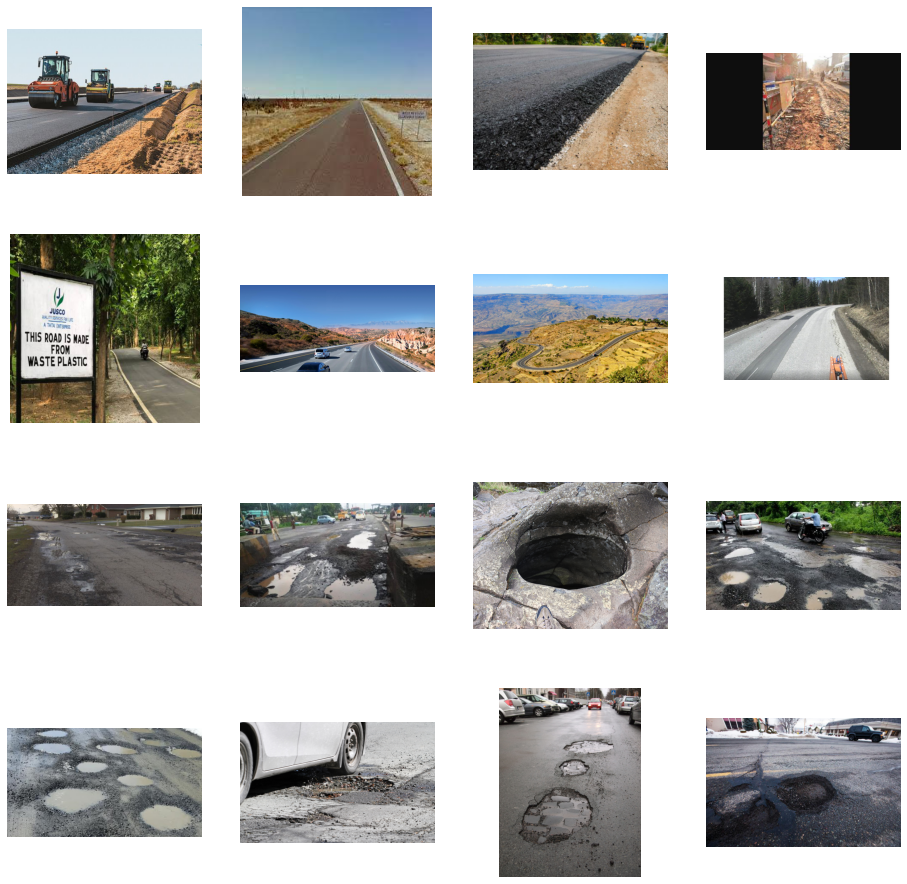

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_normal_pic = [os.path.join(train_normal_dir, fname) 
                for fname in train_normal_names[pic_index-8:pic_index]]
next_potholes_pic = [os.path.join(train_potholes_dir, fname) 
                for fname in train_potholes_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_normal_pic + next_potholes_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


#### Data Preprocessing

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.7 MB/s 


In [ ]:
from tensorflow_addons.image import gaussian_filter2d as gaussian

def apply_blur(img):
  return gaussian(image=img, sigma=1.5)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=apply_blur)

validation_datagen = ImageDataGenerator(rescale=1/255, preprocessing_function=apply_blur)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/pothole-dataset/train/',  # This is the source directory for training images
        classes = ['normal', 'potholes'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/pothole-dataset/validation/',  # This is the source directory for training images
        classes = ['normal', 'potholes'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=24,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Building the Model

Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dropout

import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(512,activation='relu'))

# Output will be between 0 and 1
# 0 for normal road, 1 for broken road
model.add(Dense(1,activation='sigmoid'))


Check model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

#### Compile the model

In [ ]:
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras import optimizers


model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = 'accuracy')
# model.compile(optimizer=RMSprop(lr=0.001), loss = 'binary_crossentropy', metrics = 'accuracy')

### Training the model

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.8746 - accuracy: 0.5142 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


8/8 [==============================] - 123s 15s/step - loss: 0.8746 - accuracy: 0.5142 - val_loss: 0.6873 - val_accuracy: 0.5052
Epoch 2/15
8/8 [==============================] - 120s 15s/step - loss: 0.5886 - accuracy: 0.6769 - val_loss: 0.4640 - val_accuracy: 0.7708
Epoch 3/15
8/8 [==============================] - 120s 16s/step - loss: 0.4114 - accuracy: 0.8385 - val_loss: 0.4053 - val_accuracy: 0.8073
Epoch 4/15
8/8 [==============================] - 120s 15s/step - loss: 0.3543 - accuracy: 0.8532 - val_loss: 0.4475 - val_accuracy: 0.8177
Epoch 5/15
8/8 [==============================] - 120s 15s/step - loss: 0.3550 - accuracy: 0.8555 - val_loss: 0.3577 - val_accuracy: 0.8281
Epoch 6/15
8/8 [==============================] - 121s 15s/step - loss: 0.3126 - accuracy: 0.8714 - val_loss: 0.3370 - val_accuracy: 0.8438
Epoch 7/15
8/8 [==============================] - 120s 15s/step - loss: 0.2745 - accuracy: 0.8896 - val_loss: 0.3181 - val_accuracy: 0.8646
Epoch 8/15
8/8 [===============

## Check accuracy

In [ ]:
model.evaluate(validation_generator)

9/9 [==============================] - 15s 2s/step - loss: 0.2335 - accuracy: 0.8950


[0.2335246056318283, 0.8949999809265137]

In [ ]:
# Load the model
model = tf.keras.models.load_model('/content/model_30epoch_93p.h5')

### Making Predictions

[0.2541651]
frustrated.jpg is normal
[0.16921699]
lagii.png is normal
[0.24211559]
mustbebrokentoo.jpg is normal
[0.00743544]
pastisalah.jpg is normal
[0.94257104]
test.jpg is broken
[0.95363337]
testok.jpg is broken
[0.90445685]
521984.jpg is broken


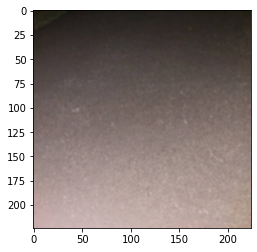

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

#uploaded = files.upload()
uploaded = [
            # 'also_normal.png',
            # 'normal.jpg',
            # 'should_be_normal.jpg',
            # 'this_should_be_normal.jpg',
            # 'incorrect_should_be_normal.jpg',
            'frustrated.jpg', 'lagii.png', 'mustbebrokentoo.jpg', 'pastisalah.jpg', 'test.jpg',
            'testok.jpg', '521984.jpg'
]

for fn in uploaded:#.keys():
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = x / 255.0
  x = gaussian(image=x, sigma=1.0)
  plt.imshow(x)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is normal")
  else:
    print(fn + " is broken")
 

In [ ]:
model.save('model_30epoch_90p_aug.h5')

## Clean Up
Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)